In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import csv
from scipy.interpolate import *
import lmfit
from scipy import signal

In [3]:
# setting up constants
vbg = 1.0
roomtemp = 298.
errresis = [20,2,200,200,0.2,0.02,0.05,2,0.01,20,200,2,0.2]
errvolt = np.array([0.05,0.005,0.005,0.005,0.0005,0.0005,0.0005,0.0005,0.0005,0.005,0.005,0.005,0.0005])
errvolt = errvolt/float(10**-3)
data = dict()

In [4]:
#functions to put in our constants
def findvrms(filename):
    t = []
    volt = []
    with open(filename,'rb') as excelcsv:
        read = csv.reader(excelcsv)
        for d in read:
            t.append(d[0])
            volt.append(d[1])
            
    t = t[2:]
    volt = volt[2:]
    t = np.array([float(i) for i in t])
    volt = np.array([float(i) for i in volt])
#     meanvolt = np.mean(volt)
    
#     volt = volt-meanvolt
    
    plt.plot(t,volt)
    plt.grid()
    return (np.mean(volt**2))

def arranging(keep, resistance, filename):  #returns a dict with resistance as index and vrms as element
    dvrms = findvrms(filename)
    keep[resistance] = dvrms
    return keep


{0: 1.9025539406865001e-05,
 47.19: 2.0315379298594999e-05,
 149.99: 2.6835132463674998e-05,
 200.9: 2.9251773823799999e-05,
 511: 4.9074136419175006e-05,
 1003.5: 7.5352306460589998e-05,
 2204: 0.000152076056364475,
 10012: 0.00053392627160157499,
 20040: 0.0011431793123988601,
 101750: 0.0026901318995822799,
 223140: 0.0033069734276359995,
 476300: 0.0086972845858594803,
 1014300: 0.0045568084343622448}

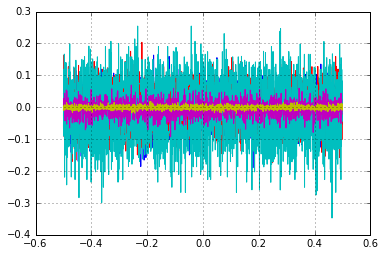

In [5]:
#fill in the data
arranging(data,101750,"scope_0.csv")
arranging(data,511,"scope_1.csv")
arranging(data,223140,"scope_2.csv")
arranging(data,1014300,"scope_3.csv")
arranging(data,1003.5,"scope_4.csv")
arranging(data,47.19,"scope_5.csv")
arranging(data,0,"scope_6.csv")
arranging(data,2204,"scope_7.csv")
arranging(data,149.99,"scope_8.csv")
arranging(data,20040,"scope_9.csv")
arranging(data,476300,"scope_10.csv")
arranging(data,10012,"scope_11.csv")
arranging(data,200.9,"scope_12.csv")

In [12]:
#extracting data into resistance and vrms in corresponding indexes
resistancex = np.array([i for i in data])
vrmsy = np.array([data[i] for i in data])
# vrmsy = np.array([4.543, 5.205, 5.471, 6.950, 8.737, 12.111, 23.22, 33.08, 46.37, 50.2, 57.54, 58.96, 59.59])
# vrmsy = vrmsy[:-5]
# errvolt = 0.05*(0.001*vrmsy)**2
# vrmsy = (vrmsy*0.001)**2 - (4.263*0.001)**2
# resistancex = np.array([
#  47.19,
#  149.99,
#  200.9,
#  511,
#  1003.5,
#  2204,
#  10012,
#  20040,
# 68320,
#  101750, 
#  223140,
#  476300,
#  1014300])
# resistancex = resistancex[:-5]


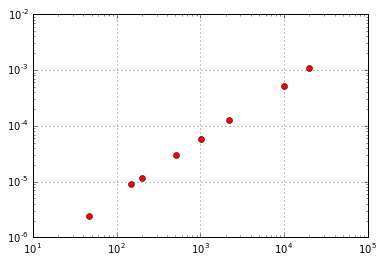

In [7]:
#plotting our x and y
plt.plot(resistancex,vrmsy,'or')
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [8]:
def thermal_model(params, x):
    A = params['A'].value
    B = params['B'].value
    C = params['C'].value
    output = A*(x**B)+C    #from data_x 
    return output

def thermal_fit(params, x, data, err):
    model = thermal_model(params, x)
    return (model-data)/err

params = lmfit.Parameters()
params.add('A', value = 1.0)
params.add('B', value = 1.0, vary=False)
params.add('C', value = 0.0, vary= False)

result = lmfit.minimize(thermal_fit, params, args = (resistancex,vrmsy, errvolt))

print result.params

Parameters([('A', <Parameter 'A', value=5.5412122722306822e-08 +/- 1.08e-09, bounds=[-inf:inf]>), ('B', <Parameter 'B', value=1.0 (fixed), bounds=[-inf:inf]>), ('C', <Parameter 'C', value=0.0 (fixed), bounds=[-inf:inf]>)])


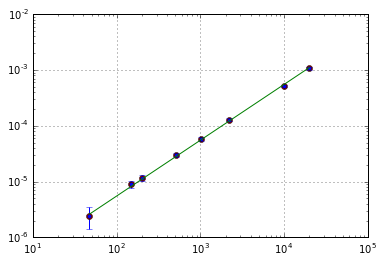

In [9]:
xfit = np.linspace(np.min(resistancex),np.max(resistancex),100)
yfit = thermal_model(result.params,xfit)

plt.plot(resistancex,vrmsy,'ro')
plt.errorbar(resistancex,vrmsy, errvolt, fmt='o', markersize=4.0)
plt.plot(xfit,yfit)
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [10]:
print result.params['A']/(4*roomtemp*3.74658348542e+12)

1.24077523741e-23


In [15]:
print resistancex
print vrmsy

[  1.00350000e+03   0.00000000e+00   2.23140000e+05   1.00120000e+04
   2.00400000e+04   2.20400000e+03   4.76300000e+05   4.71900000e+01
   1.49990000e+02   2.00900000e+02   1.01750000e+05   1.01430000e+06
   5.11000000e+02]
[  7.53523065e-05   1.90255394e-05   3.30697343e-03   5.33926272e-04
   1.14317931e-03   1.52076056e-04   8.69728459e-03   2.03153793e-05
   2.68351325e-05   2.92517738e-05   2.69013190e-03   4.55680843e-03
   4.90741364e-05]
